# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)

In [ ]:
!pip install networkx
!pip install tqdm
!pip install turicreate
!pip install karateclub

In [ ]:
import json
import pandas as pd

!mkdir /root/.kaggle/
# Installing the Kaggle package
!pip install kaggle 

#!!!fill your api key!!!
api_token = {"username":"","key":""}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

!mkdir ./datasets
# Creating a dataset directory
!mkdir ./datasets/marvel-universe-social-network

# download the dataset from Kaggle and unzip it
!kaggle datasets download csanhueza/the-marvel-universe-social-network -f hero-network.csv -p ./datasets/marvel-universe-social-network
!kaggle datasets download csanhueza/the-marvel-universe-social-network -f nodes.csv -p ./datasets/marvel-universe-social-network
!unzip ./datasets/marvel-universe-social-network/*.zip  -d ./datasets/marvel-universe-social-network
# Load data
df_marvel = pd.read_csv('./datasets/marvel-universe-social-network/hero-network.csv')
df_nodes = pd.read_csv('./datasets/marvel-universe-social-network/nodes.csv')

  0% 0.00/2.32M [00:00<?, ?B/s]
100% 2.32M/2.32M [00:00<00:00, 75.8MB/s]
  0% 0.00/289k [00:00<?, ?B/s]
100% 289k/289k [00:00<00:00, 36.8MB/s]
Archive:  ./datasets/marvel-universe-social-network/hero-network.csv.zip
  inflating: ./datasets/marvel-universe-social-network/hero-network.csv  


In [ ]:
#Adding heros types
from statistics import mode
import networkx as nx

nodes_keys = list(df_nodes.node)

def get_hero_type(hero_name):
  exact_type_found = False
  partial_match_types = []
  # Finding the character type
  hero_type = "no_type"
  for node_key in nodes_keys:
    if exact_type_found:
      break

    if hero_name == node_key: # if the keys are an exact match 
      hero_type = df_nodes[df_nodes["node"] == hero_name]["type"].iloc[0] # then use the type and stop searching
      exact_type_found = True
    elif hero_name in node_key or node_key in hero_name: #else, if the match is only partial ("LIKE")
      partial_match_types.append(df_nodes[df_nodes["node"] == node_key]["type"].iloc[0]) # then add the type to a list and use the most common value as the type
  if not exact_type_found:
    hero_type = mode(partial_match_types)# mode
  return hero_type


#SELECTING ONLY THE TOP 150 MOST CONNECTED VERTECIES
df_marvel_no_duplicates = df_marvel.drop_duplicates()

hero_1_groupby = df_marvel_no_duplicates.groupby("hero1")
hero_2_groupby = df_marvel_no_duplicates.groupby("hero2")

hero_1_count = hero_1_groupby.size().to_frame(name='counts hero 1').sort_values('counts hero 1', ascending=0)
hero_2_count = hero_2_groupby.size().to_frame(name='counts hero 2').sort_values('counts hero 2', ascending=0)

joined_df = pd.merge(hero_1_count, hero_2_count, left_index=True, right_index=True)
joined_df["total counts"] = joined_df["counts hero 1"] +joined_df["counts hero 2"] 
joined_df = joined_df[["total counts"]] 
most_friendly = joined_df.iloc[:150].index.tolist()
df_marvel_most_friendly = df_marvel[df_marvel["hero1"].isin(most_friendly) & df_marvel["hero2"].isin(most_friendly)]

marvel_graph = nx.DiGraph()
heroes_names = set(df_marvel_most_friendly.hero1) | set(df_marvel_most_friendly.hero2)

for hero in heroes_names:
  marvel_graph.add_node(hero, hero_type=get_hero_type(hero))

for _, row in df_marvel_most_friendly.iterrows():
  marvel_graph.add_edge(row["hero1"], row["hero2"])


nx.info(marvel_graph)

'DiGraph with 150 nodes and 14809 edges'

In [ ]:
# This is for predicting missing links scenario
import random 
from tqdm import tqdm_notebook as tqdm 

def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]


def get_random_friend_of_friend(g, v, max_tries=100):
    for i in range(max_tries):
        if len(list(g.neighbors(v))) == 0:
          return None
        u = random.choice(list(g.neighbors(v)))
        if len(list(g.neighbors(u))) ==0:
          return None
        x = random.choice(list(g.neighbors(u)))
        if not g.has_edge(v,x):
            return x
    return None
    
def select_random_non_existing_links_distance_2(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        v = random.choice(v_list)
        u = get_random_friend_of_friend(g, v)
        if u is None:
            continue
        select_links.add((v,u))
    return list(select_links)

postive_links = select_random_existing_links(marvel_graph,7000)
negative_links = select_random_non_existing_links_distance_2(marvel_graph, 7000)


def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set

def get_features_dict(g,u, v, embeddings_dict=None):#, embeddings_length=0):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            # 'jaccard_coefficient': list(nx.jaccard_coefficient(g,[(u,v)]))[0][2],
            # 'adamic_adar_index': list(nx.adamic_adar_index(g,[(u,v)]))[0][2],
            'friends_measure': friends_measure(g, u,v)
        }
        if embeddings_dict is not None:
          for i in range(len(embeddings_dict[v])):
            d[f"embed_v_{i}"]= embeddings_dict[v][i]
          for i in range(len(embeddings_dict[v])):
            d[f"embed_u_{i}"]= embeddings_dict[u][i]
    except e:
        print(e)
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(marvel_graph, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(marvel_graph, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)
links_features[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/7000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/7000 [00:00<?, ?it/s]

{'class': True,
 'common_friends': 81,
 'degree_u': 94,
 'degree_v': 110,
 'friends_measure': 902,
 'total_friends': 123}

In [ ]:
import turicreate as tc
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'friends_measure', 'class' ]
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)

test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
predictors = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'friends_measure']
cls = tc.create(train,features=predictors, target="class")
cls

Train size 11201
Test size: 2799
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 10640

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.019921     | 0.801786          | 0.782531            | 0.583291          | 0.593210            |

| 2         | 0.034659     | 0.808929          | 0.795009            | 0.519417          | 0.535100            |

| 3         | 0.047961     | 0.814380          | 0.796791            | 0.480277          | 0.501497            |

| 4         | 0.061495     | 0.817951          | 0.802139            | 0.451832          | 0.475272            |

| 5         | 0.076108     | 0.819831          | 0.803922            | 0.432350          | 0.460438            |

| 10        | 0.136602     | 0.830263          | 0.805704            | 0.386506          | 0.430433            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 10640

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.021457     | 0.792293          | 0.768271            | 0.471084          | 0.501405            |

| 2         | 0.034656     | 0.796992          | 0.780749            | 0.457918          | 0.482863            |

| 3         | 0.047032     | 0.801692          | 0.780749            | 0.454429          | 0.477777            |

| 4         | 0.057598     | 0.807519          | 0.793226            | 0.451761          | 0.478050            |

| 5         | 0.072984     | 0.803007          | 0.782531            | 0.456061          | 0.484732            |

| 10        | 0.122200     | 0.808271          | 0.784314            | 0.453903          | 0.481423            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 10640

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.022483     | 0.801786          | 0.782531            | 0.456745          | 0.488614            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 10640

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

Number of coefficients    : 6

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 5.000000  | 0.031792     | 0.642857          | 0.622103            |

| 1         | 7        | 1.250000  | 0.079517     | 0.729793          | 0.759358            |

| 2         | 13       | 3.707343  | 0.103343     | 0.726692          | 0.713012            |

| 3         | 14       | 3.707343  | 0.113493     | 0.735338          | 0.723708            |

| 4         | 15       | 3.707343  | 0.121653     | 0.755545          | 0.746881            |

| 9         | 26       | 1.000000  | 0.178951     | 0.754417          | 0.737968            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 10640

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

Number of coefficients      : 6

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.028034     | 0.753665          | 0.734403            |

| 2         | 3        | 0.041798     | 0.753008          | 0.729055            |

| 3         | 4        | 0.068218     | 0.752350          | 0.725490            |

| 4         | 5        | 0.095077     | 0.752256          | 0.725490            |

| 5         | 6        | 0.113176     | 0.752256          | 0.725490            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.8057040998217468
PROGRESS: RandomForestClassifier          : 0.7843137254901961
PROGRESS: DecisionTreeClassifier          : 0.7825311942959001
PROGRESS: SVMClassifier                   : 0.7379679144385026
PROGRESS: LogisticClassifier              : 0.7254901960784313
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


Class                          : BoostedTreesClassifier

Schema
------
Number of examples             : 10640
Number of feature columns      : 5
Number of unpacked features    : 5
Number of classes              : 2

Settings
--------
Number of trees                : 10
Max tree depth                 : 6
Training time (sec)            : 0.1377
Training accuracy              : 0.8303
Validation accuracy            : 0.8057
Training log_loss              : 0.3865
Validation log_loss            : 0.4304
Training auc                   : 0.9109
Validation auc                 : 0.8788

In [ ]:
results = cls.evaluate(test)
results

{'accuracy': 0.8031439799928546,
 'auc': 0.8822134031860964,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  351  |
 |      1       |        1        |  1090 |
 |      0       |        1        |  200  |
 |      0       |        0        |  1158 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.7982424020505309,
 'log_loss': 0.43235925488221144,
 'precision': 0.8449612403100775,
 'recall': 0.7564191533657183,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1441 | 1358 |
 |   0.001   | 1.0 | 1.0 | 1441 | 1358 |
 |   0.002   | 1.0 |

In [ ]:
#fitting the graph for karateclub 
nodes_dict = dict(list(zip(marvel_graph.nodes(), range(len(marvel_graph.nodes())))))
reverse_nodes_dict = {v:k for k,v in nodes_dict.items()}

karateclub_marvel_graph = nx.DiGraph()
for e1,e2 in marvel_graph.edges():
  karateclub_marvel_graph.add_edge(nodes_dict[e1], nodes_dict[e2])
print(nx.info(marvel_graph))
print(nx.info(karateclub_marvel_graph))

DiGraph with 150 nodes and 14809 edges
DiGraph with 150 nodes and 14809 edges


In [ ]:
import karateclub

karateclub_model = karateclub.DeepWalk()
karateclub_model.fit(karateclub_marvel_graph)
embedding = karateclub_model.get_embedding()
embedding_dict = {reverse_nodes_dict[i]:embedding[i] for i in range(len(embedding)) }


In [ ]:
def get_features_dict(g,u, v, embeddings_dict=None):#, embeddings_length=0):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            # 'jaccard_coefficient': list(nx.jaccard_coefficient(g,[(u,v)]))[0][2],
            # 'adamic_adar_index': list(nx.adamic_adar_index(g,[(u,v)]))[0][2],
            'friends_measure': friends_measure(g, u,v)
        }
        if embeddings_dict is not None:
            for i in range(len(embeddings_dict[v])):
                d[f"embed_v_{i}"]= embeddings_dict[v][i]
            for i in range(len(embeddings_dict[v])):
                d[f"embed_u_{i}"]= embeddings_dict[u][i]
    except e:
        print(e)
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

In [ ]:
links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(marvel_graph, u,v, embedding_dict)
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(marvel_graph, u,v, embedding_dict)
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)
links_features[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/7000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/7000 [00:00<?, ?it/s]

{'class': True,
 'common_friends': 81,
 'degree_u': 94,
 'degree_v': 110,
 'embed_u_0': 0.06931069,
 'embed_u_1': -0.059494592,
 'embed_u_10': -0.043813456,
 'embed_u_100': 0.13346972,
 'embed_u_101': -0.070688434,
 'embed_u_102': -0.020034898,
 'embed_u_103': 0.03861937,
 'embed_u_104': -0.047337003,
 'embed_u_105': 0.16425501,
 'embed_u_106': -0.0075685885,
 'embed_u_107': -0.080295466,
 'embed_u_108': -0.05325034,
 'embed_u_109': -0.0056437715,
 'embed_u_11': 0.07888493,
 'embed_u_110': 0.037856843,
 'embed_u_111': -0.13960114,
 'embed_u_112': -0.071489714,
 'embed_u_113': -0.03454001,
 'embed_u_114': -0.15936308,
 'embed_u_115': 0.027262235,
 'embed_u_116': -0.09657439,
 'embed_u_117': -0.086578734,
 'embed_u_118': -0.054320253,
 'embed_u_119': 0.017065406,
 'embed_u_12': -0.022354426,
 'embed_u_120': 0.06957754,
 'embed_u_121': -0.0048695942,
 'embed_u_122': 0.008124739,
 'embed_u_123': -0.19869998,
 'embed_u_124': -0.09236835,
 'embed_u_125': 0.0020474144,
 'embed_u_126': 0.14855

In [ ]:
embeddings_features =  [f"embed_v_{i}" for i in range(len(embedding[0]))]
embeddings_features.extend([f"embed_u_{i}" for i in range(len(embedding[0]))])
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'friends_measure', 'class']
features_list.extend(embeddings_features)
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)

test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
predictors = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'friends_measure']
predictors.extend(embeddings_features)
cls = tc.classifier.create(train,features=predictors, target="class")
cls

Train size 11242
Test size: 2758
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 10679

Number of classes           : 2

Number of feature columns   : 261

Number of unpacked features : 261

Number of coefficients      : 262

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 3.296142     | 0.789119          | 0.795737            |

| 2         | 3        | 4.961712     | 0.794363          | 0.801066            |

| 3         | 4        | 6.618112     | 0.795955          | 0.797513            |

| 4         | 5        | 8.312675     | 0.796236          | 0.797513            |

| 5         | 6        | 9.938175     | 0.796142          | 0.797513            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

SVM:

--------------------------------------------------------

Number of examples          : 10679

Number of classes           : 2

Number of feature columns   : 261

Number of unpacked features : 261

Number of coefficients    : 262

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 4        | 0.250000  | 0.363711     | 0.623467          | 0.658970            |

| 1         | 7        | 1.250000  | 0.668448     | 0.631801          | 0.660746            |

| 2         | 12       | 1.079641  | 1.131692     | 0.635265          | 0.678508            |

| 3         | 15       | 0.883202  | 1.437071     | 0.641446          | 0.682060            |

| 4         | 16       | 1.000000  | 1.596873     | 0.665980          | 0.683837            |

| 9         | 22       | 0.955907  | 2.482633     | 0.732278          | 0.754885            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.7975133214920072
PROGRESS: SVMClassifier                   : 0.7548845470692718
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


Class                          : LogisticClassifier

Schema
------
Number of coefficients         : 262
Number of examples             : 10679
Number of classes              : 2
Number of feature columns      : 261
Number of unpacked features    : 261

Hyperparameters
---------------
L1 penalty                     : 0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 5
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 10.018

Settings
--------
Log-likelihood                 : 4976.2758

Highest Positive Coefficients
-----------------------------
embed_v_95                     : 87.2435
embed_v_60                     : 77.4521
embed_v_124                    : 75.7157
embed_v_1                      : 73.9306
embed_v_77                     : 73.3386

Lowest Negative Coefficients
----------------------------
embed_v_89                     : -85.00

In [ ]:
results = cls.evaluate(test)
results

{'accuracy': 0.7722987672226251,
 'auc': 0.8501167715007067,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        1        |  1001 |
 |      1       |        0        |  386  |
 |      0       |        1        |  242  |
 |      0       |        0        |  1129 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.7612167300380229,
 'log_loss': 0.49847407858188053,
 'precision': 0.8053097345132744,
 'recall': 0.7217015140591204,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1387 | 1371 |
 |   0.001   | 1.0 | 1.0 | 1387 | 1371 |
 |   0.002   | 1.0 |

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

In [ ]:
!mkdir ./datasets/enron
!wget -O ./datasets/enron/enron_mail_20150507.tar.gz https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
!tar -zxvf ./datasets/enron/enron_mail_20150507.tar.gz -C ./datasets/enron/
!ls ./datasets/enron

Streaming output truncated to the last 5000 lines.
maildir/campbell-l/all_documents/1572.
maildir/campbell-l/all_documents/759.
maildir/campbell-l/all_documents/538.
maildir/campbell-l/all_documents/876.
maildir/campbell-l/all_documents/321.
maildir/campbell-l/all_documents/990.
maildir/campbell-l/all_documents/1842.
maildir/campbell-l/all_documents/1460.
maildir/campbell-l/all_documents/1840.
maildir/campbell-l/all_documents/274.
maildir/campbell-l/all_documents/448.
maildir/campbell-l/all_documents/1692.
maildir/campbell-l/all_documents/400.
maildir/campbell-l/all_documents/224.
maildir/campbell-l/all_documents/188.
maildir/campbell-l/all_documents/1670.
maildir/campbell-l/all_documents/1678.
maildir/campbell-l/all_documents/706.
maildir/campbell-l/all_documents/254.
maildir/campbell-l/all_documents/1429.
maildir/campbell-l/all_documents/1704.
maildir/campbell-l/all_documents/529.
maildir/campbell-l/all_documents/1039.
maildir/campbell-l/all_documents/1694.
maildir/campbell-l/all_doc

In [ ]:
import os, re
from glob import glob

enron_data_set_path = "./datasets/enron/maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"{enron_data_set_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

eneron_graph = nx.DiGraph()
eneron_graph.add_edges_from(links)
print(nx.info(eneron_graph))


Found 99279 files


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/99279 [00:00<?, ?it/s]

DiGraph with 18590 nodes and 32392 edges


In [ ]:
def remove_mail_suffix(email_address):
  pattern = re.compile('@\S*\s?')
  return pattern.sub('', email_address) 

In [ ]:
#By Degree
import operator
sorted_by_degree = sorted(dict(eneron_graph.degree()).items(), key=operator.itemgetter(1), reverse=True)
top_10_by_degree = sorted_by_degree[:10]
top_10_by_degree = [(remove_mail_suffix(element[0]),element[1]) for element in top_10_by_degree]
top_10_by_degree

[('jeff.dasovich', 683),
 ('sara.shackleton', 641),
 ('tana.jones', 584),
 ('gerald.nemec', 534),
 ('kay.mann', 471),
 ('kenneth.lay', 466),
 ('vince.kaminski', 434),
 ('debra.perlingiere', 420),
 ('sally.beck', 369),
 ('jeff.skilling', 363)]

In [ ]:
#By the number of connected communities
from networkx.algorithms.community import greedy_modularity_communities
cc = greedy_modularity_communities(eneron_graph.to_undirected())

# add the community each node belong to
for i in range(len(cc)):
    c = cc[i]
    if len(c) < 2:
        continue # skip this community
    for n in c:
        eneron_graph.nodes[n]['community'] = i 

node_communities_num_dict = {}
for v in eneron_graph.nodes():
    connected_communities = [eneron_graph.nodes[u]['community'] for u in eneron_graph.neighbors(v) if 'community' in eneron_graph.nodes[u]]
    node_communities_num_dict[v] = len(set(connected_communities))

sorted_by_communities = sorted(node_communities_num_dict.items(), key=operator.itemgetter(1), reverse=True)
top_10_by_communities = sorted_by_communities[:10] 
top_10_by_communities = [(remove_mail_suffix(element[0]),element[1]) for element in top_10_by_communities]
top_10_by_communities

[('jeff.dasovich', 15),
 ('sara.shackleton', 14),
 ('elizabeth.sager', 14),
 ('mark.haedicke', 14),
 ('sally.beck', 13),
 ('richard.sanders', 13),
 ('tana.jones', 13),
 ('susan.scott', 13),
 ('mark.taylor', 13),
 ('benjamin.rogers', 13)]

In [ ]:
#PageRank 
sorted_by_pagerank = sorted(dict(nx.pagerank(eneron_graph)).items(), key=operator.itemgetter(1), reverse=True)
top_10_by_pagerank = sorted_by_pagerank[:10]
top_10_by_pagerank = [(remove_mail_suffix(element[0]),element[1]) for element in top_10_by_pagerank]
top_10_by_pagerank

[('kenneth.lay', 0.0111733231422288),
 ('jeff.skilling', 0.00860134389507152),
 ('emca', 0.003760850805793813),
 ('sally.beck', 0.00362388200031541),
 ('greg.whalley', 0.003162501654673328),
 ('rick.buy', 0.003067774690307123),
 ('gerald.nemec', 0.0030609135318493486),
 ('john.lavorato', 0.002974880717744395),
 ('sara.shackleton', 0.00289497110417319),
 ('joe.parks', 0.002827062290329174)]

In [ ]:
#4th metric, for fun. Closeness Centrality
sorted_by_closeness = sorted(dict(nx.closeness_centrality(eneron_graph)).items(), key=operator.itemgetter(1), reverse=True)
top_10_by_closeness = sorted_by_closeness[:10]
top_10_by_closeness = [(remove_mail_suffix(element[0]),element[1]) for element in top_10_by_closeness]
top_10_by_closeness

[('john.lavorato', 0.07941566308677966),
 ('tim.belden', 0.07940443270240763),
 ('kenneth.lay', 0.07938759308003332),
 ('greg.whalley', 0.07827538103507013),
 ('sally.beck', 0.07627118253940174),
 ('louise.kitchen', 0.07604908862396906),
 ('k..allen', 0.0745497140009394),
 ('rick.buy', 0.07334227349204227),
 ('scott.neal', 0.07328962290087784),
 ('john.arnold', 0.07193292926659949)]

In [ ]:
#Load the roles list
!wget -O ./datasets/enron/employees http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/roles.txt
with open('./datasets/enron/employees') as f:
    lines = f.readlines()
roles = []
for index, line in enumerate(lines):
  splited = line.split("\t")
  username = splited[0]
  full_name = splited[1].split("    ")[0].strip()
  # if '\n' in full_name:
  #   full_name = full_name.strip()
  #   roles.append({'username':username,"full_name":full_name, "role":role, "role_details":role_details}) #full name	role	role details
  #   continue
    
  i=0
  role=None
  for s in splited[1].split("    ")[1:]:
    i+=1
    if s != '':
      role = s.strip()
      if role == "N/A":
        role=None
      break
  # if '\n' in role:
  #   role = role.strip()
  #   roles.append({'username':username,"full_name":full_name, "role":role, "role_details":role_details}) #full name	role	role details
  #   continue
  role_details = None
  for j in range(i+1, len(splited[1].split("    "))):
    if splited[1].split("    ")[j] != '':
      # print(j)
      # print(splited[1].split("    ")[j].strip())
      role_details = splited[1].split("    ")[j].strip()
      if role_details == "N/A":
        role_details = None
      break

  roles.append({'username':username,"full_name":full_name, "role":role, "role_details":role_details}) #full name	role	role details

roles_df = pd.DataFrame(roles)
roles_df = roles_df[roles_df["role"].isna() == False]
roles_df

--2021-11-22 21:41:26--  http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/roles.txt
Resolving www.inf.ed.ac.uk (www.inf.ed.ac.uk)... 129.215.33.176
Connecting to www.inf.ed.ac.uk (www.inf.ed.ac.uk)|129.215.33.176|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8867 (8.7K) [text/plain]
Saving to: ‘./datasets/enron/employees’

./datasets/enron/em 100%[===================>]   8.66K  --.-KB/s    in 0s      

2021-11-22 21:41:27 (123 MB/s) - ‘./datasets/enron/employees’ saved [8867/8867]



,username,full_name,role,role_details
0,albert.meyers,Albert Meyers,Employee,Specialist
1,a..martin,Thomas Martin,Vice President,None
3,andrew.lewis,Andrew Lewis,Director,None
4,andy.zipper,Andy Zipper,Vice President,Enron Online
5,a..shankman,Jeffrey Shankman,President,Enron Global Mkts
...,...,...,...,...
177,tori.kuykendall,Tori Kuykendall,Trader,None
178,tracy.geaccone,Tracy Geaccone,Employee,None
179,vince.kaminski,Vince Kaminski,Manager,Risk Management Head
182,w..delainey,David Delainey,CEO,Enron North America and Enron Enery Services


In [ ]:
#calculating precision@10
def precision_at_10(roles_df, top_10):
  managment_roles = ["CEO","Manager","President","Director","Vice President","Managing Director"]

  count=0
  roles_not_found = []
  for employee_user_name,_ in top_10:
    if employee_user_name in set(roles_df["username"]):
      role = list(roles_df[roles_df["username"] == employee_user_name].role)[0]
      if role in managment_roles:
        count = count + 1
    else:
      roles_not_found.append(employee_user_name)
  return count/10,roles_not_found


In [ ]:
precision_at_10_score, roles_not_found = precision_at_10(roles_df, top_10_by_degree)
print(f"Degree - precision_at_10_score: {precision_at_10_score}")
print(f"Degree - roles_not_found: {roles_not_found}\n")
precision_at_10_score, roles_not_found = precision_at_10(roles_df, top_10_by_communities)
print(f"Connected Communities - precision_at_10_score: {precision_at_10_score}")
print(f"Connected Communities - roles_not_found: {roles_not_found}\n")
precision_at_10_score, roles_not_found = precision_at_10(roles_df, top_10_by_pagerank)
print(f"PageRank - precision_at_10_score: {precision_at_10_score}")
print(f"PageRank - roles_not_found: {roles_not_found}\n")
precision_at_10_score, roles_not_found = precision_at_10(roles_df, top_10_by_closeness)
print(f"Closeness Centrality - precision_at_10_score: {precision_at_10_score}")
print(f"Closeness Centrality - roles_not_found: {roles_not_found}\n")

print("We can observe major differences in the precision@10 scores. ")
print("HOWEVER! The roles of the employees that were not found are unknown\nThe actual precision@10 score is possibly higher")


Degree - precision_at_10_score: 0.3
Degree - roles_not_found: ['sara.shackleton', 'tana.jones', 'gerald.nemec', 'debra.perlingiere']

Connected Communities - precision_at_10_score: 0.1
Connected Communities - roles_not_found: ['sara.shackleton', 'tana.jones', 'susan.scott']

PageRank - precision_at_10_score: 0.5
PageRank - roles_not_found: ['emca', 'gerald.nemec', 'sara.shackleton', 'joe.parks']

Closeness Centrality - precision_at_10_score: 0.8
Closeness Centrality - roles_not_found: ['tim.belden']

We can observe major differences in the precision@10 scores. 
HOWEVER! The roles of the employees that were not found are unknown
The actual precision@10 score is possibly higher


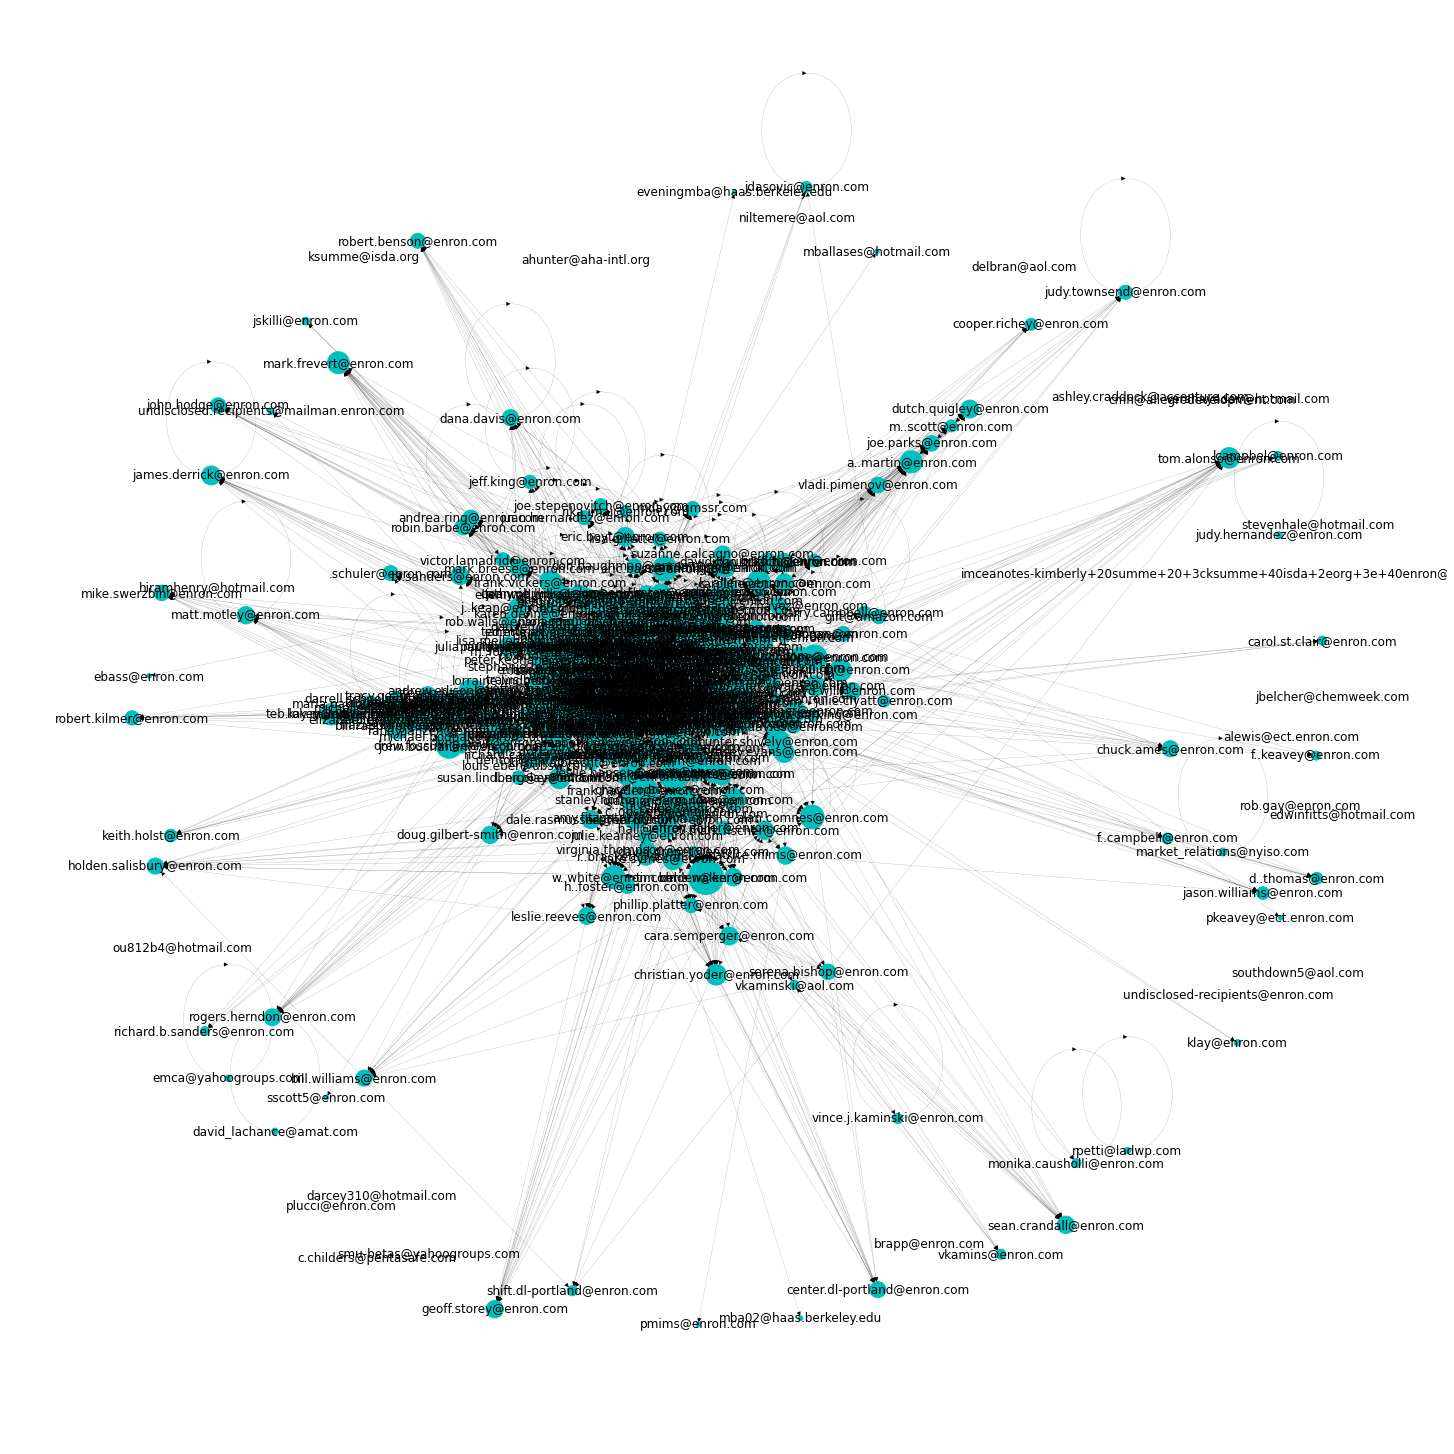

In [ ]:
#visiualizing the degree 
import matplotlib.pyplot as plt
%matplotlib inline

nodes_sub_set = [n for n,degree in dict(eneron_graph.degree()).items() if degree > 20]
eneron_sub_graph = eneron_graph.subgraph(nodes_sub_set)
plt.figure(figsize=(20,20))
# nx.write_gml(eneron_sub_graph, "./datasets/enron/maildir/network.gml")
nodes_colors = ["c" for i in range(len(eneron_sub_graph.nodes()))]
sizes = [degree*20 for n,degree in dict(eneron_sub_graph.degree()).items()]

nx.draw_spring(eneron_sub_graph, with_labels=True, node_size=sizes, node_color=nodes_colors, width=0.1 )